In [3]:
import pandas as pd
import ast
import nltk
import re
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np
import gensim
import json
import pickle
from nltk.util import ngrams
#import pyLDAvis.gensim
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
tweets = pd.read_csv('tweets_at_trump.csv')
tweets = tweets.drop(['Unnamed: 0'], axis=1)
tweets = tweets.drop(['index'], axis=1)
tweets = tweets.drop(['user'], axis=1)

<BarContainer object of 5 artists>

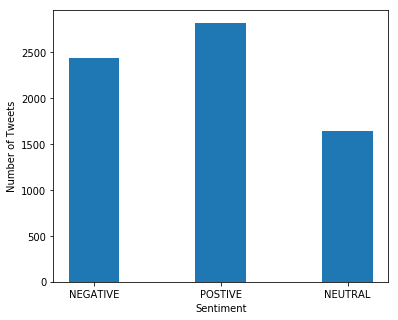

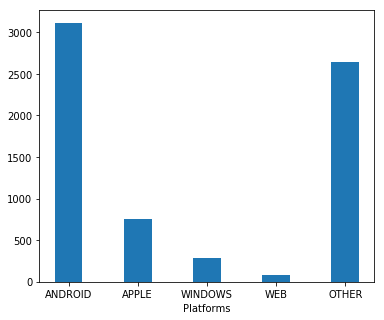

In [5]:
neutral = 0
neg = 0
pos = 0

for t in tweets['sentiment_type']:
    if t == 'NEUTRAL': 
        neutral += 1
    elif t == 'NEGATIVE':
        neg += 1
    else:
        pos += 1

droid = 0
apple = 0
windows = 0
web = 0
other = 0
for s in tweets['source']:
    if s == 'android':
        droid += 1
    elif s == 'iphone' or s == 'ipad' or s == 'macos':
        apple += 1
    elif s == 'web':
        web += 1
    elif s == 'windows':
        windows += 1
    else:
        other += 1

source_counts = {'ANDROID': droid, 'APPLE': apple, 'WINDOWS': windows, 'WEB': web, 'OTHER': other}
type_counts = {'NEGATIVE': neg, 'POSTIVE': pos, 'NEUTRAL': neutral}

plt.figure(figsize=(6,5))
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
plt.bar(list(type_counts.keys()), list(type_counts.values()), width=0.4)

plt.figure(figsize=(6,5))
plt.xlabel('Platforms')
plt.bar(list(source_counts.keys()), list(source_counts.values()), width=0.4)

# Group the tweets by location

The tweets are grouped by location and then each group's corresponding dataframe is added to a list. This list will be used to build an LDA model for each group of tweets to extract topics for each place individually.

In [6]:
tweets['zipcode'] = tweets.zipcode.astype('category')
places = tweets['place'].unique()

tweets_by_place = []
df_by_place = tweets.groupby('place')

for i in range(len(places)):
    tweets_by_place.append(df_by_place.get_group(places[i]))

The tweets are then cleaned and removed of stop words. Each tweet is then converted to a bigram. The tokenized tweets are used as a dictionary and as a corpus for the LDA model implemented by Gensim. The function below takes each group of tweets and does a parameter search for a topic model. The parameter being searched is the number of topics. For each parameter value the function fits an LDA model to the tweets and then measures the coherence of the model. Each parameter and the corresponding coherence is kept track of.

In [7]:
from gensim.models.coherencemodel import CoherenceModel

# This function will be used on each dataframe in tweets_by_place 
def search_params(tweets, num_topics):
    coherences = []
    topic_num = []
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tok_twts = []
    n = 1
    for tweet in tweets['tweet']:
        tokens = nltk.tokenize.word_tokenize(tweet)
        tokens = [token for token in tokens if token not in en_stop]
        tokens = [token.lower() for token in tokens]
        ngrams = zip(*[tokens[i:] for i in range(n)])
        tokens = [" ".join(ngram) for ngram in ngrams]
        tok_twts.append(tokens)
    
    dictionary = gensim.corpora.Dictionary(tok_twts)
    corpus = [dictionary.doc2bow(tweet) for tweet in tok_twts]
    
    if len(corpus[0]) == 0:
        print(tweets)
        exit()
    #print(len(corpus))
    #print(corpus)
    for k in range(1, num_topics):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                                   iterations=50, 
                                                   num_topics=k, 
                                                   id2word=dictionary, 
                                                   passes=20)
        
    
        cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
        coherences.append(cm.get_coherence())
        topic_num.append(k)
        
    return coherences, topic_num, dictionary, corpus

In [8]:
def find_best(tweets, num_topics):
    
    # Run parameter search on a group of tweets
    c, k, dictionary, corpus = search_params(tweets, num_topics)
    
    # The coherence list and topic numbers list correspond to eachother by position.
    # By getting the position with the best coherence we can index into k for the best
    # parameter.
    best_pos = np.argmax(c)
    best_k = k[best_pos]
    best_c = c[best_pos]
    
    return best_k, best_c, c, k, dictionary, corpus

In [13]:
def build_best_model(k_topics, d, corpus):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                               iterations=15, 
                                               num_topics=k_topics, 
                                               id2word=d, 
                                               passes=20
                                              )
    
    cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
    c = cm.get_coherence()
    return ldamodel, c

In [16]:

model_by_place = []

# Build LDA for each group of tweets
for i in range(len(tweets_by_place)):
    if places[i-1] == 'Lansing, MI':
        print("SKIPPING: ", places[i])
        continue
    
    # Get best topic numbers for each model
    best_k, best_c, c_list, k_list, dictionary, corpus = find_best(tweets_by_place[i], 7)
    
    # Run model with that number of topics
    model, coherence = build_best_model(best_k, dictionary, corpus)
    
    # Keep track of city, state for each model (This is stored in places list)
    model_by_place.append( (model, places[i]) )
    print(places[i])

Folsom, CA
Fairfield, CA
Hinesville, GA
Carlsbad, CA
Columbus, OH
Manlius, NY
La Quinta, CA
Las Vegas, NV
San Antonio, TX
Los Angeles, CA
Tallahassee, FL
Southaven, MS
White Plains, NY
Renton, WA
Crescent Beach, FL
Summit City, CA
North Bellmore, NY
Queens, NY
San Diego, CA
Bend, OR
Chicago, IL
Hemet, CA
Raleigh, NC
Pine Lake Park, NJ
Dana Point, CA
Glenview, IL
Houston, TX
Port St Lucie, FL
Clearwater, FL
Hampton, MI
Honolulu, HI
Zephyrhills, FL
Shreveport, LA
Pequannock, NJ
Newport, KY
Nashville, TN
Lake Hiawatha, NJ
Prunedale, CA
Minneapolis, MN
Oklahoma City, OK
Verona, NJ
Denver, CO
Long Beach, CA
Glenpool, OK
Seattle, WA
Rome, GA
Henderson, NV
Modesto, CA
Lancaster, CA
Zellwood, FL
Chesterfield, MO
Providence, RI
Missoula, MT
Coram, NY
Atlanta, GA
Fort Wayne, IN
Boston, MA
Portland, OR
Waynesboro, VA
El Paso, TX
Fresno, CA
Decatur, IL
Philadelphia, PA
Stonington, CT
Calimesa, CA
Brent, FL
Pleasant Point, TX
Napa, CA
Scottsdale, AZ
Mariemont, OH
St Louis, MO
Bellevue, WA
Rolling M

North Providence, RI
Mira Monte, CA
Town and Country, MO
Rockport, MA
Sandy, UT
Colesville, MD
Medford, OR
Gainesville, FL
New Britain, CT
Orangeburg, NY
West Wareham, MA
Hendersonville, NC
Crete, NE
Fort Collins, CO
Hilliard, OH
Round Lake Beach, IL
North Bethesda, MD
Fall City, WA
Ohio, PA
Shorewood, WI
Cetronia, PA
Manassas, VA
Montgomery, AL
Delmar, MD
Sanford, FL
Chester, VA
Lithia Springs, GA
Lawrence, PA
West Jefferson, OH
Pawleys Island, SC
Hobbs, NM
Briarcliff Manor, NY
Gulf Gate Estates, FL
Levittown, NY
Ione, CA
Midland, TX
Middletown, CT
North Bergen, NJ
Prescott, AZ
Smith Mills, MA
White House, TN
Weston, WV
Tifton, GA
Tonawanda, NY
Cliffwood Beach, NJ
Silverton, OR
Gulfport, MS
Scanlon, MN
Kirkland, WA
Babylon, NY
Lake Butler, FL
Altavista, VA
Corpus Christi, TX
Pennsville, NJ
Bridgeport, NY
Lomita, CA
Springfield, VA
Johnson City, TN
West Valley City, UT
Pueblo, CO
Lake Wazeecha, WI
Salt Lake City, UT
Closter, NJ
Redmond, OR
Pineville, NC
North Vacherie, LA
Hereford, TX


KeyboardInterrupt: 

In [3]:
#en_stop = set(nltk.corpus.stopwords.words('english'))
#tok_twts = []
#n = 2
#for tweet in tweets['tweet']:
 #   tokens = nltk.tokenize.word_tokenize(tweet)
 #   tokens = [token for token in tokens if token not in en_stop]
  #  tokens = [token.lower() for token in tokens]
  #  ngrams = zip(*[tokens[i:] for i in range(n)])
   # tokens = [" ".join(ngram) for ngram in ngrams]
    #tok_twts.append(tokens)
    
#dictionary = gensim.corpora.Dictionary(tok_twts)
#corpus = [dictionary.doc2bow(tweet) for tweet in tok_twts]

In [20]:
#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)


In [37]:
#NUM_TOPICS = 12
#ldamodel = gensim.models.ldamodel.LdaModel(corpus, iterations=50, num_topics=NUM_TOPICS, id2word=dictionary, passes=20)
#ldamodel.save('model.gensim')

C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)


In [30]:
#x = ldamodel.print_topics()

In [38]:
#cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
#cm.get_coherence()

0.5617708938970447